<a href="https://colab.research.google.com/github/priyeshroy10155/computervision/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%cd /content/drive/MyDrive/Resnet50

In [3]:
#! unzip /content/drive/MyDrive/Resnet50/ResNet50-master.zip

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [5]:
data_path=os.listdir('/content/drive/MyDrive/Resnet50/ResNet50-master/rooms_dataset')
room_types=os.listdir('/content/drive/MyDrive/Resnet50/ResNet50-master/rooms_dataset')
print('Types of rooms found:',len(data_path))
print(room_types)

Types of rooms found: 3
['living_room', 'dining_room', 'bed_room']


In [6]:
rooms=[]
for item in room_types:
  all_rooms=os.listdir('/content/drive/MyDrive/Resnet50/ResNet50-master/rooms_dataset'+'/'+item)
  for room in all_rooms:
    rooms.append((item, str('/content/drive/MyDrive/Resnet50/ResNet50-master/rooms_dataset'+'/'+item)+'/'+room))
print(rooms[0])

('living_room', '/content/drive/MyDrive/Resnet50/ResNet50-master/rooms_dataset/living_room/photo-1554995207-c18c203602cb.jpg')


In [7]:
rooms_df=pd.DataFrame(data=rooms,columns=['room type','image'])
# print(rooms_df.head())
# print(rooms_df.tail())
print(len(rooms_df))
rooms_count=rooms_df['room type'].value_counts()
print(rooms_count)

393
bed_room       159
living_room    148
dining_room     86
Name: room type, dtype: int64


In [8]:
path='/content/drive/MyDrive/Resnet50/ResNet50-master/rooms_dataset/'
im_size=224
images=[]
labels=[]
for i in room_types:
    
  data_path=path+str(i)
  filenames=[i for i in os.listdir(data_path)]
  #print(filenames)
  for f in filenames:

    img=cv2.imread(data_path+'/'+f)
     #print(img)
    img=cv2.resize(img, (224,224))
    images.append(img)
    labels.append(i)


In [9]:
#Transform arry to numpy
images=np.array(images)
images.shape

(393, 224, 224, 3)

In [10]:
images=images.astype('float32')/255.0

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
y=rooms_df['room type'].values
y=y.reshape(-1,1)
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])],     remainder='passthrough')
Y= columnTransformer.fit_transform(y)
Y.shape


(393, 3)

In [12]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
images, Y=shuffle(images, Y, random_state=1)
train_x, test_x, train_y, test_y =train_test_split(images, Y, test_size=0.05,random_state=415)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(373, 224, 224, 3)
(20, 224, 224, 3)
(373, 3)
(20, 3)


**ResNet**

In [13]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

**Identity Block**

In [19]:
# x is input, y=F(x)
# identity block simply means input should be equal to output. 
#  y = x + F(x)   the layers in a traditional network are learning the true output H(x)
# F(x) = y - x   the layers in a residual network are learning the residual F(x)
# Hence, the name: Residual Block.



def identity_block(X, f, filters, stage, block):
    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [20]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)

      
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [21]:
#Each ResNet block is either 2 layer deep
def ResNet50(input_shape=(224, 224, 3), classes=3):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) #3,3 padding

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7 
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # convolutional_block is a function defined above. Convolutional_block have 3 layers.
    #filters=[64, 64, 256] first 64 is for 1st layer and 2nd 64 is for 2nd layer and 256 is for 3rd layer of convultional block   
    # below are the conv layers from convolutional_block function
    #X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    #X = Conv2D(F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    #X = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
   
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b') 
    #X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    #X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    #X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
  
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    #X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    #X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    #X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)


    ### START CODE HERE ###

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [22]:
model = ResNet50(input_shape = (224, 224, 3), classes = 3)

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [36]:
model.fit(train_x, train_y, epochs = 50, batch_size = 32) 

Epoch 1/50
12/12 [==============================] - 4s 328ms/step - loss: 1.7305 - accuracy: 0.5416
Epoch 2/50
12/12 [==============================] - 4s 333ms/step - loss: 1.3681 - accuracy: 0.4960
Epoch 3/50
12/12 [==============================] - 4s 337ms/step - loss: 1.2328 - accuracy: 0.5040
Epoch 4/50
12/12 [==============================] - 4s 337ms/step - loss: 0.9841 - accuracy: 0.6247
Epoch 5/50
12/12 [==============================] - 4s 336ms/step - loss: 0.8791 - accuracy: 0.6461
Epoch 6/50
12/12 [==============================] - 4s 332ms/step - loss: 0.7356 - accuracy: 0.7239
Epoch 7/50
12/12 [==============================] - 4s 328ms/step - loss: 0.6596 - accuracy: 0.7534
Epoch 8/50
12/12 [==============================] - 4s 325ms/step - loss: 0.5268 - accuracy: 0.8150
Epoch 9/50
12/12 [==============================] - 4s 322ms/step - loss: 0.4528 - accuracy: 0.8257
Epoch 10/50
12/12 [==============================] - 4s 320ms/step - loss: 0.3900 - accuracy: 0.8472

In [37]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1/1 [==============================] - 0s 108ms/step - loss: 2.4993 - accuracy: 0.5000
Loss = 2.499295711517334
Test Accuracy = 0.5


Input image shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 79ms/step
[[0. 1. 0.]]


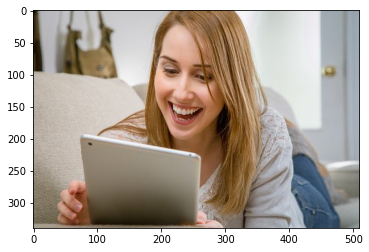

In [41]:
from tensorflow.keras.preprocessing import image
from matplotlib.pyplot import imread
#img_path = 'test_room.jpg'
img_path = '/content/drive/MyDrive/Resnet50/ResNet50-master/rooms_dataset/living_room/woman-2099465__340.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)
print(model.predict(x))

In [ ]:
``